## Time to get your hands dirty.  The transient Universe

Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]

Figure from Gezari (2021) ["Tidal Disruption Events", review](https://arxiv.org/abs/2104.14580)

2. Sudden flares of active galactic nuclei

Figure from  Graham et al (2021) ["A Candidate Electromagnetic Counterpart to the Binary Black Hole Merger Gravitational Wave Event S190521ga"](https://arxiv.org/abs/2006.14122)

3. Supernovae.

Figure from  Jha et al (2019) ["Observational Properties of Thermonuclear Supernovae
"](https://arxiv.org/abs/1908.02303)

### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [1]:
# LECTURE 11 -> MCMC - emcee
# TRANSIENT UNIVERSE: Transient phenomena include Tidal distruption events, Sudden flares of active galactic nuclei and Supernovae.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
import emcee
import corner

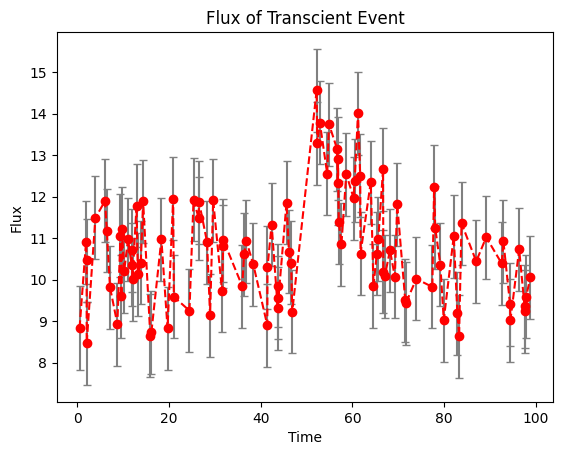

In [3]:
# (100x3) numpy array containing some time-series measurements from a transient phenomenon. Data in arbitrary units
# 1 column: TIME
# 2 column: FLUX
# 3 column: FLUX HOMOESCEDASTIC UNCERTAINTIES

data = np.load("transient.npy") # returns a matrix

TIME = data[:, 0]
FLUX = data[:, 1]
Sflux = data[:, 2]

plt.errorbar(TIME, FLUX, Sflux, capsize=3, fmt="r--o", ecolor = "grey", label = 'data')

plt.title("Flux of Transcient Event")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

In [ ]:
# MODEL is a sharp burst with an exponential tail rising above a nominal background level -> 4 PARAMETERS
def burst (TIME, t0, b, alfa, A): # t0=time of burst | alpha=rapidity of burst die off | A=amplitude 
    y = np.zeros(len(TIME))
    
    for i in range(len(TIME)):
        if TIME[i] < t0:
            y[i] = b
        else: 
            y[i] = b + A * np.exp(-alfa * (TIME[i]-t0))
    
    return y 

# LOG-LIKELIHOOD for the model
def LOGlikelihood(TIME, FLUX, Sflux, t0, b, alfa, A):
    model = burst(TIME, t0, b, alfa, A)
    return -0.5 * np.sum(((FLUX - model) / Sflux) ** 2 + np.log(2 * np.pi * Sflux ** 2))

# Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of t0, b, alfa, A
# MCMC sampler = emcee

# LOG-PRIOR FUNCTIONS
def LOGprior(t0, b, alfa, A):
    if not (0 <= t0 <= 100 and 0 <= b <= 50 and 0 <= A <= 50 and np.exp(-5) <= alfa <= np.exp(5)): 
        return -np.inf  # point exluded correctly -> to avoid  warnings/NaN caused by log(0.0)
    log_prior_t0_b_A = np.log(1 / (100 * 50 * 50))
    log_prior_alfa = np.log(1 / (10 * alfa))  # P(alfa) = P(log alfa) * d(log alfa)/d(alfa)
    return log_prior_t0_b_A + log_prior_alfa
    
# LOG POSTERIOR FUNCTION -> emcee wants ln of posterior pdf - posterior = prior * likelihood
def LOGposterior(theta, FLUX, TIME, Sflux): # emcee expects only one argoment theta
    t0, b, alfa, A = theta
    lp = LOGprior(t0, b, alfa, A)

    if not np.isfinite(lp): # if lp = -inf o NaN -> point exluded
        return -np.inf 
    
    return lp + LOGlikelihood(TIME, FLUX, Sflux, t0, b, alfa, A)

done
(10, 70000, 4)
(600000, 4)
[154.99046059  59.13041243 549.54436151 612.29065441]


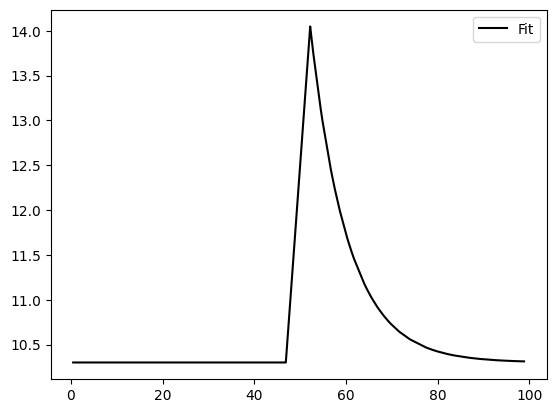

In [ ]:
# MCMC sampling with emcee library
ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
burn = 10000  # burn-in period to let chains stabilize
nsteps = 70000  # number of MCMC steps to take for each walker -> to have enough ~ 50 x tau

# initialize theta (parameters) 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim)) # each walker starts from a different point (4 dimensions)
sampler = emcee.EnsembleSampler(nwalkers, ndim, LOGposterior, args=(FLUX, TIME, Sflux)) 
sampler.run_mcmc(starting_guesses, nsteps) 
 
# sampler.chain is of shape (nwalkers, nsteps, ndim) - throw-out the burn-in points and reshape, uniting the values from the walkers
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")
print(sampler.chain.shape) # original chain structure
print(emcee_trace.shape) # burned and flattened chain

# thin the chain by selecting only points every auto-correlation length -> how much the point depends on the previous ones
tau = sampler.get_autocorr_time()
print(tau)

# max -> samples as independent as possible, even if it means discarding more points than necessary -> QUALITY OVER QUANTITY
thin = int(np.max(tau)) + 1 # +1 -> so that always int(tau) != 0 + tau is estimated so I add an error

# after thinning, the chain is more indipendent
emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True)

# median of each parameter: median of each column
t0, b, alfa, A = np.median(emcee_trace, axis=0)

# errors: difference between the median and the 5% / 95% percentile values (90% credible region of the marginalized distribution)
t0_5, b_5, alfa_5, A_5 = np.percentile(emcee_trace, 5, axis=0)
t0_95, b_95, alfa_95, A_95 = np.percentile(emcee_trace, 95, axis=0)

BURST = burst(TIME, t0, b, alfa, A) # Fit
plt.plot(TIME, BURST, label='Fit', color='black')

plt.legend()
plt.show()

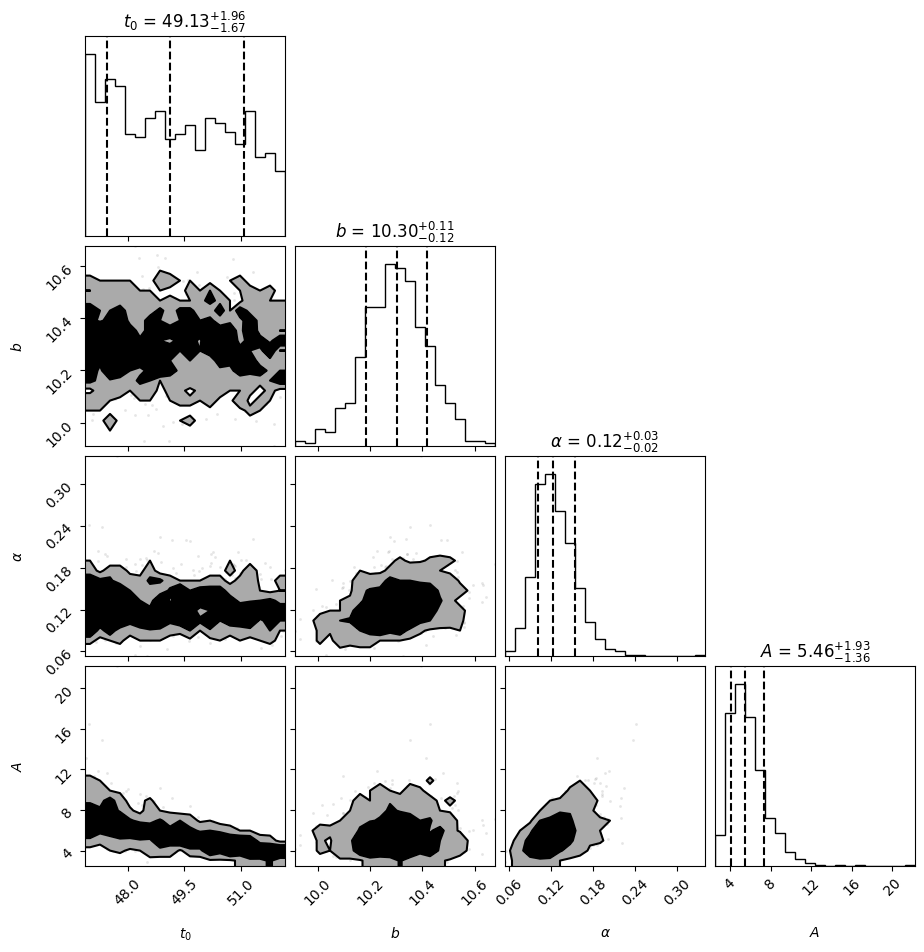

90% credible region:
t0   = 49.13 (+2.64/-2.08)
b    = 10.30 (+0.19/-0.20)
alfa = 0.1230 (+0.0547/-0.0360)
A    = 5.46 (+3.47/-1.91)


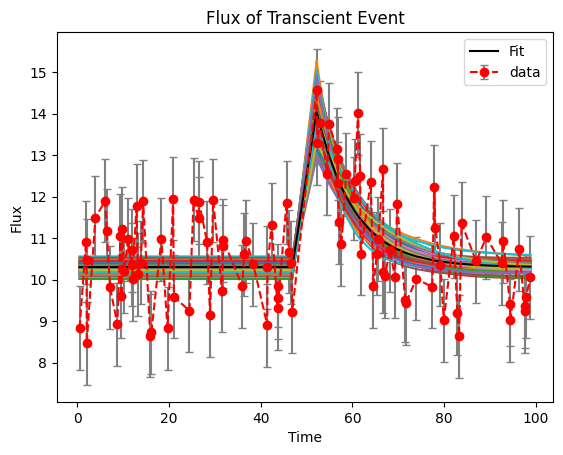

In [6]:
# Corner plot of the 4-D parameter space, with labels, [68, 95] credible levels and quantiles, and titles
labels = [r"$t_0$", r"$b$", r"$\alpha$", r"$A$"]

fig = corner.corner(
    emcee_trace,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84], # For 68% credible interval
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95), # 68% and 95% credible contours
    plot_density=True,
    fill_contours=True
)

plt.show()

print("90% credible region:")
print(f"t0   = {t0:.2f} (+{t0_95 - t0:.2f}/-{t0 - t0_5:.2f})")
print(f"b    = {b:.2f} (+{b_95 - b:.2f}/-{b - b_5:.2f})")
print(f"alfa = {alfa:.4f} (+{alfa_95 - alfa:.4f}/-{alfa - alfa_5:.4f})")
print(f"A    = {A:.2f} (+{A_95 - A:.2f}/-{A - A_5:.2f})")

# Choose 100 random samples from the burned, thinned chain and plot the 100 corresponding burst time-series along with the original data
# These are showing the posterior spread of model solutions that are consistent with the data.

plt.errorbar(TIME, FLUX, Sflux, capsize=3, fmt="r--o", ecolor = "grey", label = 'data')

plt.title("Flux of Transcient Event")
plt.xlabel("Time")
plt.ylabel("Flux")

INDEX = np.random.choice(len(emcee_trace), 100, replace=False)

for ind in INDEX:
    t0_t, b_t, alfa_t, A_t = emcee_trace[ind]
    BURST = burst(TIME, t0_t, b_t, alfa_t, A_t) 
    plt.plot(TIME, BURST)

BURST = burst(TIME, t0, b, alfa, A) # Fit - BEST VALUES
plt.plot(TIME, BURST, label='Fit', color='black')

plt.legend()
plt.show()